# Traning the supervise model on our pylot dataset. Weizmann Human Action Dataset

In [3]:
import torch
print(torch.cuda.is_available())


True


In [9]:
# sense/frame_sampler.py

import cv2   # OpenCV library for reading videos and images

def sample_frames(video_path, step=10):
    """
    Extract frames from a video at regular intervals.

    video_path: path to the video file
    step: keep 1 frame every 'step' frames (default = 10)
    """

    # Create a VideoCapture object to read the video file
    cap = cv2.VideoCapture(video_path)

    frames = []   # List to store the sampled frames
    count = 0     # Counter to track frame index

    # Loop until the video ends or cannot be read
    while cap.isOpened():
        ret, frame = cap.read()   # ret=True if frame is read successfully

        if not ret:
            break   # Stop if video ends or frame cannot be read

        # Keep only every 'step' frame
        if count % step == 0:
            frames.append(frame)   # Save the frame

        count += 1   # Move to next frame index

    cap.release()   # Release the video file
    return frames   # Return the list of sampled frames


In [10]:
# Preprocessing dataset
import os
import numpy as np
from ultralytics import YOLO


# Path to your raw dataset
RAW_DATASET_DIR = "Dataset"

# Path where processed skeletons will be saved
OUTPUT_DIR = "Processed"

# Load YOLOv8 pose model
pose_model = YOLO("yolov8n-pose.pt")   # lightweight and fast


def extract_keypoints_from_frame(frame):
    """
    Runs YOLOv8 pose on a frame and returns 17 keypoints (x, y).
    If no person is detected, returns None.
    """

    results = pose_model(frame, verbose=False)

    # YOLO returns a list; take first result
    result = results[0]

    if len(result.keypoints) == 0:
        return None  # no person detected

    # Take the first detected person
    kpts = result.keypoints[0].xy[0].cpu().numpy()  # shape (17, 2)

    return kpts


def process_video(video_path, save_path):
    """
    Process a single video:
    1. Sample frames
    2. Extract skeletons
    3. Save as .npy file
    """

    frames = sample_frames(video_path, step=10)
    skeletons = []

    for frame in frames:
        keypoints = extract_keypoints_from_frame(frame)

        # If no person detected, skip frame
        if keypoints is None:
            continue

        skeletons.append(keypoints)

    if len(skeletons) == 0:
        print(f"WARNING: No skeletons extracted for {video_path}")
        return

    skeletons = np.array(skeletons)  # shape (num_frames, 17, 2)

    np.save(save_path, skeletons)
    print(f"Saved: {save_path}  shape={skeletons.shape}")


def prepare_dataset():
    """
    Loop through all action folders and videos.
    Convert each video into a skeleton .npy file.
    """

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    for action in os.listdir(RAW_DATASET_DIR):
        action_path = os.path.join(RAW_DATASET_DIR, action)

        if not os.path.isdir(action_path):
            continue

        output_action_dir = os.path.join(OUTPUT_DIR, action)
        os.makedirs(output_action_dir, exist_ok=True)

        for video_file in os.listdir(action_path):
            if not video_file.lower().endswith((".mp4", ".avi", ".mov")):
                continue

            video_path = os.path.join(action_path, video_file)

            save_name = os.path.splitext(video_file)[0] + ".npy"
            save_path = os.path.join(output_action_dir, save_name)

            process_video(video_path, save_path)


# Run preprocessing
prepare_dataset()


Saved: Processed\bend\daria_bend.npy  shape=(9, 17, 2)
Saved: Processed\bend\denis_bend.npy  shape=(9, 17, 2)
Saved: Processed\bend\eli_bend.npy  shape=(7, 17, 2)
Saved: Processed\bend\ido_bend.npy  shape=(7, 17, 2)
Saved: Processed\bend\ira_bend.npy  shape=(10, 17, 2)
Saved: Processed\bend\lena_bend.npy  shape=(7, 17, 2)
Saved: Processed\bend\lyova_bend.npy  shape=(7, 17, 2)
Saved: Processed\bend\moshe_bend.npy  shape=(7, 17, 2)
Saved: Processed\bend\shahar_bend.npy  shape=(7, 17, 2)
Saved: Processed\jack\daria_jack.npy  shape=(9, 17, 2)
Saved: Processed\jack\denis_jack.npy  shape=(6, 17, 2)
Saved: Processed\jack\eli_jack.npy  shape=(6, 17, 2)
Saved: Processed\jack\ido_jack.npy  shape=(6, 17, 2)
Saved: Processed\jack\ira_jack.npy  shape=(7, 17, 2)
Saved: Processed\jack\lena_jack.npy  shape=(15, 17, 2)
Saved: Processed\jack\lyova_jack.npy  shape=(6, 17, 2)
Saved: Processed\jack\moshe_jack.npy  shape=(11, 17, 2)
Saved: Processed\jack\shahar_jack.npy  shape=(11, 17, 2)
Saved: Processed\j

In [11]:
# Extracting the skeleton 
import os

import torch
from torch.utils.data import Dataset

class SkeletonDataset(Dataset):
    """
    Custom PyTorch Dataset for loading skeleton-based HAR data.

    Each .npy file contains a sequence of skeleton frames:
        shape = (num_frames, 17, 2)

    For M-LeNet, we convert each frame into a 34×34 tensor image.
    Each frame becomes ONE training sample.

    The dataset:
        - Loads all .npy files from Processed/<class_name>/
        - Assigns a numeric label based on folder name
        - Converts each skeleton frame into a 34×34 tensor
    """

    def __init__(self, root_dir, class_to_idx, transform=None):
        """
        root_dir: path to Processed/ folder
        class_to_idx: dictionary mapping class names → numeric labels
        transform: optional transforms (not needed for now)
        """
        self.root_dir = root_dir
        self.class_to_idx = class_to_idx
        self.transform = transform

        # List to store (file_path, label)
        self.samples = []

        # Walk through each class folder
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            label = class_to_idx[class_name]  # This uses the name of the class to label it

            # Add each .npy file inside the class folder
            for file in os.listdir(class_path):
                if file.endswith(".npy"):
                    self.samples.append(
                        (os.path.join(class_path, file), label)
                    )

    def __len__(self):
        """Return total number of skeleton frames across all videos."""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load one .npy file, pick ONE frame from it,
        convert to 34×34 tensor image, return (image, label).
        """

        file_path, label = self.samples[idx]

        # Load skeleton sequence: shape (num_frames, 17, 2)
        seq = np.load(file_path)

        # Pick a random frame from the sequence
        frame = seq[np.random.randint(0, len(seq))]

        # Flatten (17,2) → (34,)
        flat = frame.reshape(-1)

        # Convert 34 → 34×34 image by repeating the vector 34 times
        img = np.tile(flat, (34, 1))  # shape (34, 34)

        # Convert to PyTorch tensor and add channel dimension
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        return img, label


In [12]:
# Map class names to numeric labels
classes = sorted(os.listdir("Processed"))
class_to_idx = {cls: i for i, cls in enumerate(classes)}

print("Class mapping:", class_to_idx)


Class mapping: {'bend': 0, 'jack': 1, 'jump': 2, 'pjump': 3, 'run': 4, 'side': 5, 'skip': 6, 'walk': 7, 'wave1': 8, 'wave2': 9}


In [13]:
# Create DataLoaders (train + test data)
from torch.utils.data import DataLoader, random_split

dataset = SkeletonDataset("Processed", class_to_idx)

# 80/20 train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [14]:
# supervised/m_lenet.py

import os
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLeNet(nn.Module):
    """
    M-LeNet: A 2D CNN for skeleton-based HAR.

    - Input:  (batch_size, 1, 34, 34)
      Each sample is a 34×34 "image" derived from skeleton data.
      (You will construct this from your 34-D skeleton representation.)

    - Architecture (high-capacity version):
        Conv2d(1 → 20, kernel=3x3)
        Conv2d(20 → 40, kernel=3x3)
        Dropout(p=0.25)
        Flatten
        FC1: 40 * 34 * 34 → 256
        FC2: 256 → 128
        FC3: 128 → num_classes
        Dropout(p=0.5) between FC layers

    - Activation: ReLU
    - Output: raw logits (to be used with nn.CrossEntropyLoss)
    """

    def __init__(self, num_classes: int):
        """
        num_classes: number of action classes (e.g., 10 for Weizmann).
        """
        super(MLeNet, self).__init__()

        # -----------------------------
        # Convolutional feature extractor
        # -----------------------------

        # First convolutional layer:
        # - Input channels: 1  (grayscale-like 34x34 skeleton image)
        # - Output channels: 20 (high-capacity first conv)
        # - Kernel size: 3x3
        # - Padding: 1 to preserve spatial size (34x34 → 34x34)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=20,
            kernel_size=3,
            padding=1
        )

        # Second convolutional layer:
        # - Input channels: 20
        # - Output channels: 40 (high-capacity second conv)
        # - Kernel size: 3x3
        # - Padding: 1 to preserve spatial size (34x34 → 34x34)
        self.conv2 = nn.Conv2d(
            in_channels=20,
            out_channels=40,
            kernel_size=3,
            padding=1
        )

        # First dropout layer (after conv stack):
        # - p = 0.25 as described
        self.dropout1 = nn.Dropout(p=0.25)

        # -----------------------------
        # Fully connected classifier
        # -----------------------------

        # After conv2, the feature map shape is:
        # (batch_size, 40, 34, 34)
        # We flatten this to a vector of size 40 * 34 * 34 per sample.
        flattened_dim = 40 * 34 * 34

        # First fully connected layer:
        # - Input:  flattened_dim
        # - Output: 256 hidden units (you can adjust, but this is reasonable)
        self.fc1 = nn.Linear(40 * 34 * 34, 256)

        # Second fully connected layer:
        # - Input: 256
        # - Output: 128
        self.fc2 = nn.Linear(256, 128)

        # Final classification layer:
        # - Input: 128
        # - Output: num_classes (one logit per class)
        self.fc3 = nn.Linear(128, num_classes)

        # Second dropout layer (between FC layers):
        # - p = 0.5 as described
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of M-LeNet.

        x shape:
            (batch_size, 1, 34, 34)

        Returns:
            logits of shape (batch_size, num_classes)
        """

        # -----------------------------
        # Convolutional feature extraction
        # -----------------------------

        # First conv + ReLU
        # Shape: (B, 1, 34, 34) → (B, 20, 34, 34)
        x = F.relu(self.conv1(x))

        # Second conv + ReLU
        # Shape: (B, 20, 34, 34) → (B, 40, 34, 34)
        x = F.relu(self.conv2(x))

        # Dropout on conv features
        x = self.dropout1(x)

        # -----------------------------
        # Flatten for fully connected layers
        # -----------------------------
        # Flatten all dimensions except batch:
        # (B, 40, 34, 34) → (B, 40*34*34)
        x = x.view(x.size(0), -1)

        # -----------------------------
        # Fully connected classifier
        # -----------------------------

        # FC1 + ReLU
        x = F.relu(self.fc1(x))

        # Dropout with p=0.5
        x = self.dropout2(x)

        # FC2 + ReLU
        x = F.relu(self.fc2(x))

        # Final FC (logits, no activation)
        x = self.fc3(x)

        # Note: we do NOT apply softmax here because
        # nn.CrossEntropyLoss expects raw logits.
        return x


In [15]:
# Training Setup (loss, optimizer, device)
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLeNet(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
# Full Training Loop
num_epochs = 2000
train_acc_list = [] 
val_acc_list = [] 
loss_list = []

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # -----------------------------
    # TRAINING LOOP
    # -----------------------------
    for images, labels in train_loader:
        images = images.to(device)   # (batch, 1, 34, 34)
        labels = labels.to(device)   # (batch,)

        optimizer.zero_grad()        # reset gradients

        outputs = model(images)      # forward pass
        loss = criterion(outputs, labels)  # compute loss

        loss.backward()              # backpropagation
        optimizer.step()             # update weights

        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # -----------------------------
    # VALIDATION LOOP
    # -----------------------------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # no gradients needed
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    # Appending accuracies for plotting
    train_acc_list.append(train_acc) 
    val_acc_list.append(val_acc) 
    loss_list.append(running_loss)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {running_loss:.4f} "
          f"Train Acc: {train_acc:.2f}% "
          f"Val Acc: {val_acc:.2f}%")


Epoch [1/2000] Loss: 85.8850 Train Acc: 13.16% Val Acc: 10.00%
Epoch [2/2000] Loss: 91.9846 Train Acc: 9.21% Val Acc: 15.00%
Epoch [3/2000] Loss: 21.4407 Train Acc: 18.42% Val Acc: 10.00%
Epoch [4/2000] Loss: 7.7826 Train Acc: 10.53% Val Acc: 15.00%
Epoch [5/2000] Loss: 6.7991 Train Acc: 11.84% Val Acc: 5.00%
Epoch [6/2000] Loss: 6.6413 Train Acc: 19.74% Val Acc: 10.00%
Epoch [7/2000] Loss: 6.5909 Train Acc: 14.47% Val Acc: 10.00%
Epoch [8/2000] Loss: 6.5765 Train Acc: 18.42% Val Acc: 15.00%
Epoch [9/2000] Loss: 6.5883 Train Acc: 13.16% Val Acc: 0.00%
Epoch [10/2000] Loss: 6.6166 Train Acc: 14.47% Val Acc: 10.00%
Epoch [11/2000] Loss: 6.4231 Train Acc: 19.74% Val Acc: 15.00%
Epoch [12/2000] Loss: 6.5999 Train Acc: 6.58% Val Acc: 15.00%
Epoch [13/2000] Loss: 6.4385 Train Acc: 13.16% Val Acc: 15.00%
Epoch [14/2000] Loss: 6.4754 Train Acc: 23.68% Val Acc: 20.00%
Epoch [15/2000] Loss: 6.3242 Train Acc: 18.42% Val Acc: 25.00%
Epoch [16/2000] Loss: 6.3257 Train Acc: 22.37% Val Acc: 15.00%
Ep

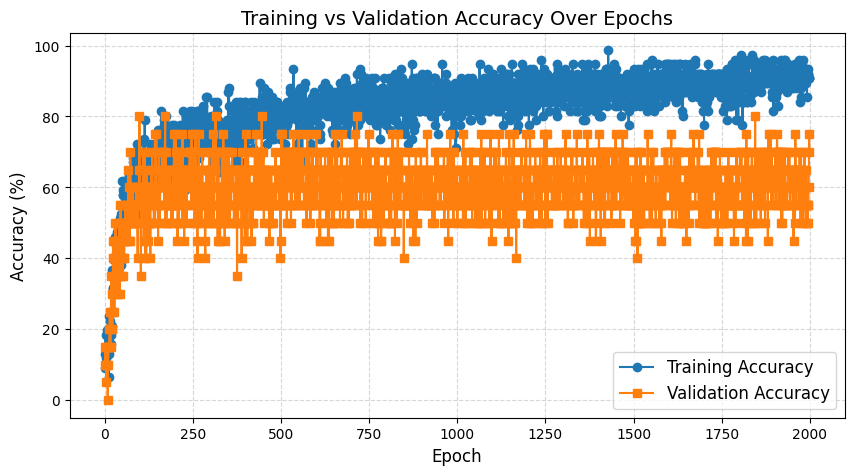

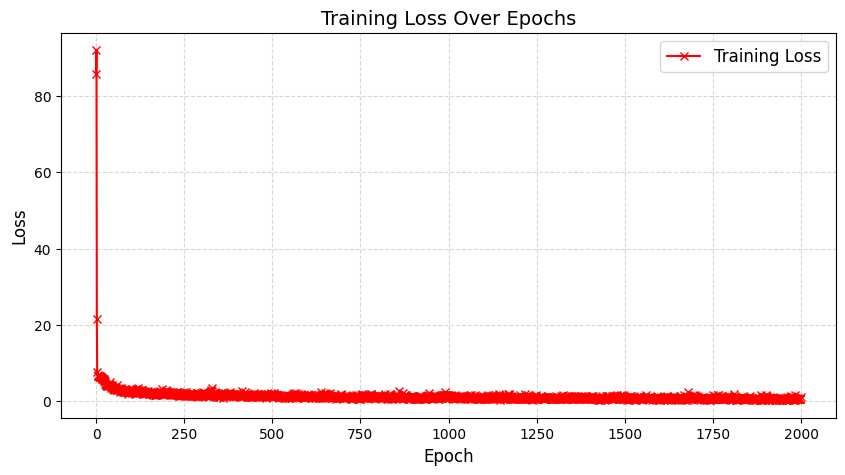

In [17]:
#  Plot Accuracy & Loss Curves
import matplotlib.pyplot as plt

# -----------------------------
# Plot Training vs Validation Accuracy
# -----------------------------
plt.figure(figsize=(10, 5))

# Plot accuracy curves
plt.plot(train_acc_list, label="Training Accuracy", marker='o')
plt.plot(val_acc_list, label="Validation Accuracy", marker='s')

# Title and labels
plt.title("Training vs Validation Accuracy Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Display the plot
plt.show()


# -----------------------------
# Plot Training Loss Curve
# -----------------------------
plt.figure(figsize=(10, 5))

# Plot loss curve
plt.plot(loss_list, label="Training Loss", color='red', marker='x')

# Title and labels
plt.title("Training Loss Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Display the plot
plt.show()
